<a href="https://colab.research.google.com/github/sebavassou/intro-ciencia-de-dados/blob/main/Exerc%C3%ADcio_1_1_CD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotnine


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2943815607.py:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2943815607.py:31: SyntaxWarning: invalid escape sequence '\s'
/usr/local/lib/python3.12/dist-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


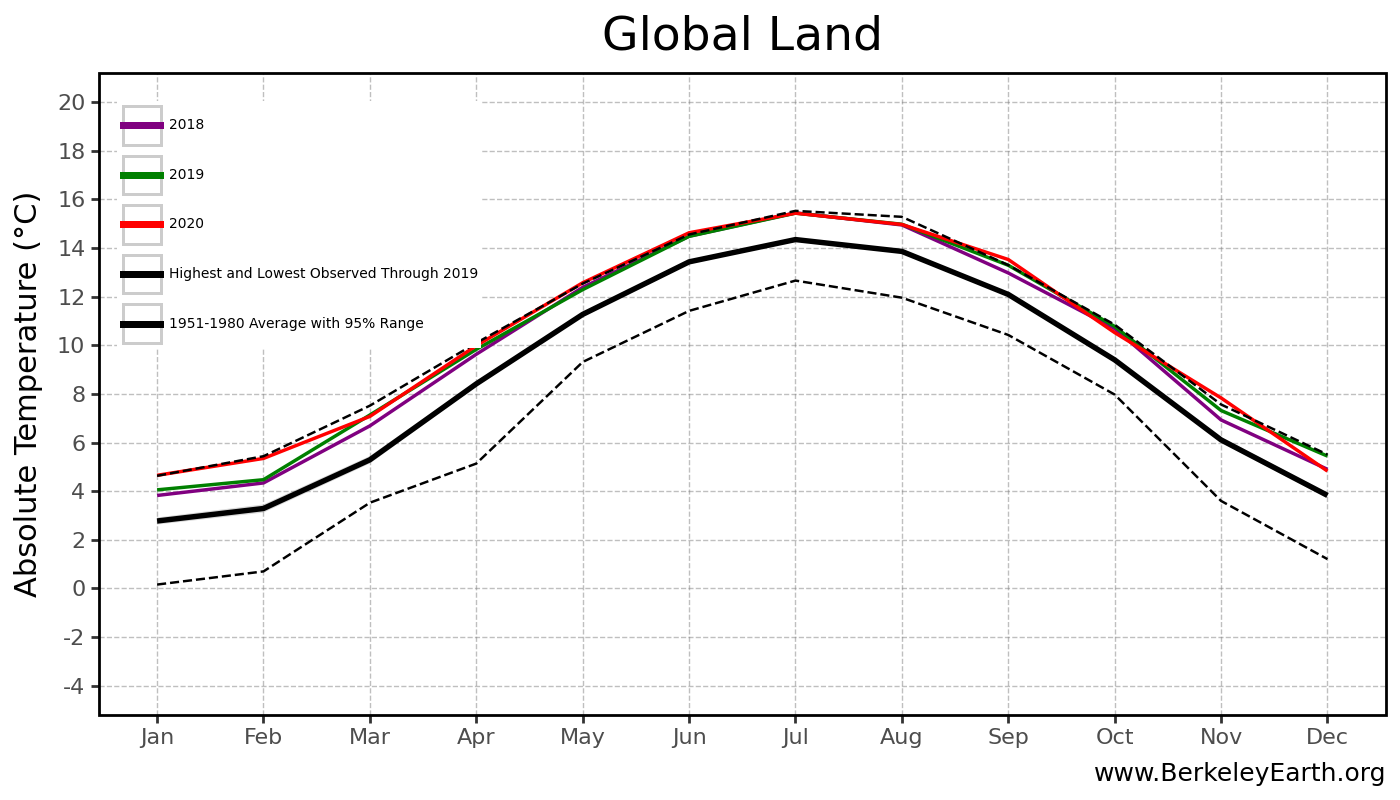

In [28]:
# Instale plotnine caso ainda não tenha

import numpy as np
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_ribbon,
    geom_line,
    scale_x_continuous,
    scale_y_continuous,
    labs,
    theme_bw,
    theme,
    element_text,
    element_line,
    element_rect,
    element_blank,
    scale_color_manual,
    guides,
    guide_legend,
    scale_fill_manual # Import scale_fill_manual
)

# Baixar e preparar os dados
tmax_df_raw = pd.read_csv(
    'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TMAX_complete.txt',
    skiprows=34, sep='\s+', header=None)
tmin_df_raw = pd.read_csv(
    'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TMIN_complete.txt',
    skiprows=34, sep='\s+', header=None)
column_names = ['Year', 'Month', 'M. Anomaly', 'M. Unc.']
tmax_df = tmax_df_raw.iloc[:, :4]
tmax_df.columns = column_names
tmin_df = tmin_df_raw.iloc[:, :4]
tmin_df.columns = column_names

# Renomear colunas principais
tmax_df = tmax_df.rename(columns={'M. Anomaly': 'TMAX_Anomaly'})
tmin_df = tmin_df.rename(columns={'M. Anomaly': 'TMIN_Anomaly'})
# Merge e climatologia
df = pd.merge(tmax_df, tmin_df, on=['Year', 'Month'])
climatology_tmin = {
     1: -2.79, 2: -2.45, 3: -0.57, 4: 2.39, 5: 5.41, 6: 7.59,
     7: 8.54, 8: 8.16, 9: 6.43, 10: 3.66, 11: 0.67, 12: -1.66
}
climatology_tmax = {
    1: 8.16, 2: 9.02, 3: 11.28, 4: 14.29, 5: 17.20, 6: 19.27,
    7: 20.11, 8: 19.68, 9: 17.95, 10: 15.06, 11: 11.71, 12: 9.11
}
climatology_avg = {month: (climatology_tmin[month] + climatology_tmax[month]) / 2 for month in range(1, 13)}
df['Climatology'] = df['Month'].map(climatology_avg)
df['TMAX_abs'] = df['TMAX_Anomaly'] + df['Climatology']
df['TMIN_abs'] = df['TMIN_Anomaly'] + df['Climatology']
df['TAVG'] = (df['TMAX_abs'] + df['TMIN_abs']) / 2.0

# Cálculo de baseline (1951-1980) e históricos
df_baseline = df[(df['Year'] >= 1951) & (df['Year'] <= 1980)].copy()
baseline_stats = df_baseline.groupby('Month')['TAVG'].agg(['mean', 'std', 'count']).reset_index()
baseline_stats['se'] = baseline_stats['std'] / np.sqrt(baseline_stats['count'])
baseline_stats['ci_lower'] = baseline_stats['mean'] - 1.96 * baseline_stats['se']
baseline_stats['ci_upper'] = baseline_stats['mean'] + 1.96 * baseline_stats['se']
df_historical = df[df['Year'] <= 2019].copy()
historical_stats = df_historical.groupby('Month')['TAVG'].agg(['min', 'max']).reset_index()

# Seleção dos anos recentes
chosen_years = [2018, 2019, 2020]
df_recent = df[df['Year'].isin(chosen_years)].copy()
df_recent['Year'] = df_recent['Year'].astype(str)
color_map = {'2020': 'red', '2019': 'green', '2018': 'purple'}

# Labels dos meses
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Montar o gráfico
from plotnine import element_rect

plot = (
    ggplot()

    # Curvas dos anos recentes
    + geom_line(df_recent, aes(x='Month', y='TAVG', color='Year'), size=0.7)
    # Linhas tracejadas máximos/mínimos
    + geom_line(historical_stats, aes(x='Month', y='min', color="'Highest and Lowest Observed Through 2019'"), linetype='dashed', size=0.5, show_legend=True)
    + geom_line(historical_stats, aes(x='Month', y='max', color="'Highest and Lowest Observed Through 2019'"), linetype='dashed', size=0.5)
    # Faixa média + intervalo de confiança da baseline climatológica
    + geom_ribbon(baseline_stats, aes(x='Month', ymin='ci_lower', ymax='ci_upper'), fill='grey', alpha=0.3, show_legend=False)
    # Linha média da baseline
    + geom_line(baseline_stats, aes(x='Month', y='mean', color="'1951-1980 Average with 95% Range'"), size=1.1)

    + scale_color_manual(values={'Highest and Lowest Observed Through 2019': 'black',  # Specify fill color for the ribbon
                                '1951-1980 Average with 95% Range': 'black',
                                **color_map},
                         guide=guide_legend(title=None))
    + scale_fill_manual(values={'1951-1980 Average with 95% Range': 'grey'}, # Specify fill color for the ribbon
                                guide=guide_legend(title=None))
    + scale_x_continuous(breaks=list(range(1,13)), labels=month_labels)
    + scale_y_continuous(
        name="Absolute Temperature (°C)",
        breaks=range(-4, 21, 2),
        limits=(-4, 20)
        # No plotnine, eixo secundário não é suportado diretamente
    )
    + labs(
        x='',
        y='Mean Temperature (°C)', # y à esquerda, simulando o padrão
        title='Global Land',
        caption='www.BerkeleyEarth.org'
    )
    + theme_bw()
    + theme(
        figure_size=(7, 4),
        plot_title=element_text(hjust=0.5, size=17),
        plot_caption=element_text(hjust=1, vjust=0, size=9),
        axis_text_x=element_text(angle=0, size=8), # Reduce x-axis label font size
        axis_text_y=element_text(size=8), # Reduce y-axis label font size
        legend_position=(0.02,0.93), # canto superior esquerdo interno
        legend_direction='vertical',
        legend_background=element_rect(fill='white', color=None), # Add white rectangle with no border
        legend_text=element_text(size=5),
        legend_box_spacing=0.01, # Reduce spacing between legend items
        panel_grid_minor_x=element_blank(),
        panel_grid_minor_y=element_blank(), # Add blank minor y grid lines
        panel_grid_major_x=element_line(colour="grey", linetype="dashed", size=0.5, alpha=0.5), # Change major y grid lines
        panel_grid_major_y=element_line(colour="grey", linetype="dashed", size=0.5, alpha=0.5), # Change major y grid lines
        panel_border=element_rect(colour="black", fill=None, size=1),
        legend_title=element_blank()
    )
)

# Exibir gráfico
plot